In [94]:
# Import libraries
import infotopo_no_prints
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.utils import Bunch
import matplotlib.patches as patches

In [95]:
# Obtain topological information metrics using infotopo
def obtain_infotopo_metrics(dataset, dimension_max=0, dimension_tot=0):

    if dimension_max == 0:
        dimension_max = 3 #dataset.shape[1]
    if dimension_tot == 0:
        dimension_tot = 9 #dataset.shape[1]
    
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo_no_prints.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset)
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut, Nfree_energy

# Convert pandas dataframe to bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

In [101]:
# read the file
x = np.load('Data\\time_series\\metabolic_pietro\\ic_0_k_0_V_10_noise_0.npy')

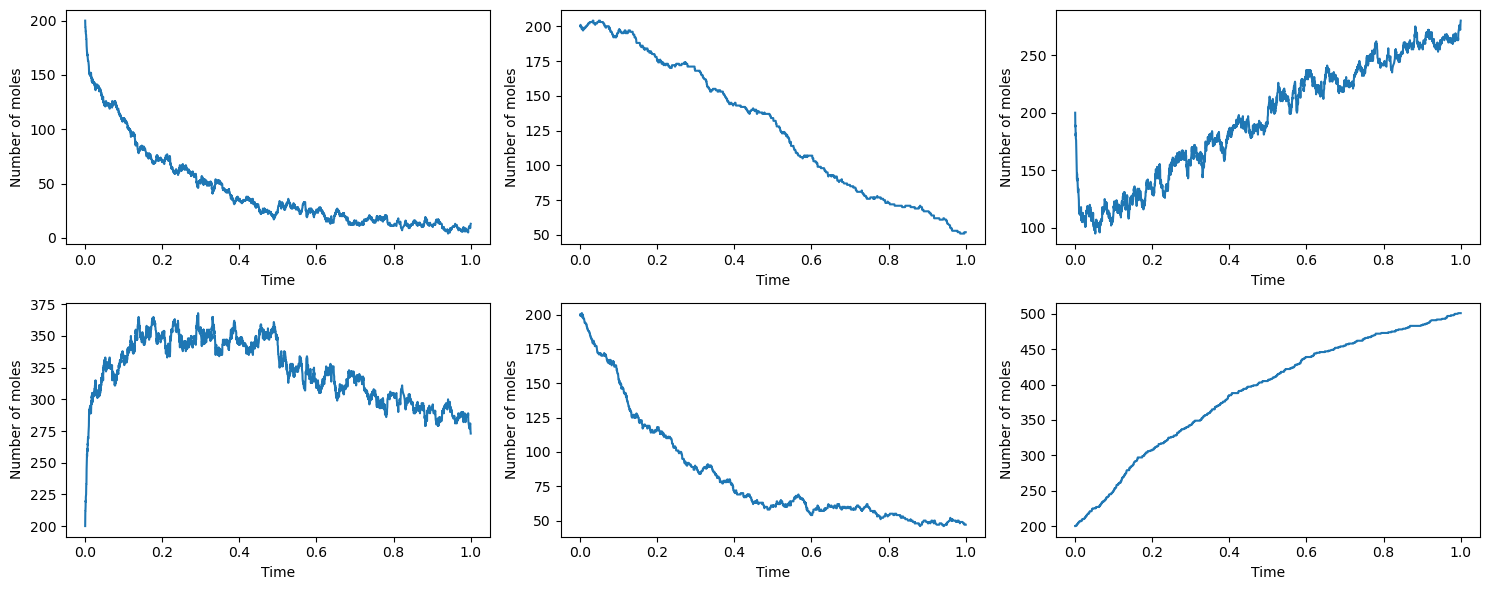

In [97]:
# Visualize the timeseries data
fig, ax = plt.subplots(2,3, figsize=(15,6))

for i in range(0, 6):
    ax[i//3,i%3].plot(x[:,0],x[:,i+1])
    ax[i//3,i%3].set_xlabel('Time')
    ax[i//3,i%3].set_ylabel('Number of moles')

plt.tight_layout()

In [98]:
# Obtain information metrics from the timeseries
Nentropie, Ninfomut, Nfree_energy = obtain_infotopo_metrics(x, dimension_max=6, dimension_tot=6)

In [99]:
# Update dictionary below significance
significance = 0.2  # given as a percentage, i.e., 20% means we want to keep the 20% most significant interactions

# Iterate over the keys grouped by their length
for key_length in set(len(key) for key in Ninfomut.keys()):
    # Filter keys of the current length
    keys_of_length = [key for key in Ninfomut if len(key) == key_length]
    
    # Sort the values corresponding to the current key length
    sorted_values = sorted(Ninfomut[key] for key in keys_of_length)
    
    # Determine the cutoff index based on the significance
    cutoff_index = int(len(sorted_values) * (1 - significance))
    cutoff_value = sorted_values[cutoff_index - 1]
    
    # Remove keys that have values below the cutoff for the current key length
    keys_to_remove = [key for key in keys_of_length if Ninfomut[key] <= cutoff_value]
    
    # Remove the identified keys from the dictionary
    for key in keys_to_remove:
        del Ninfomut[key]

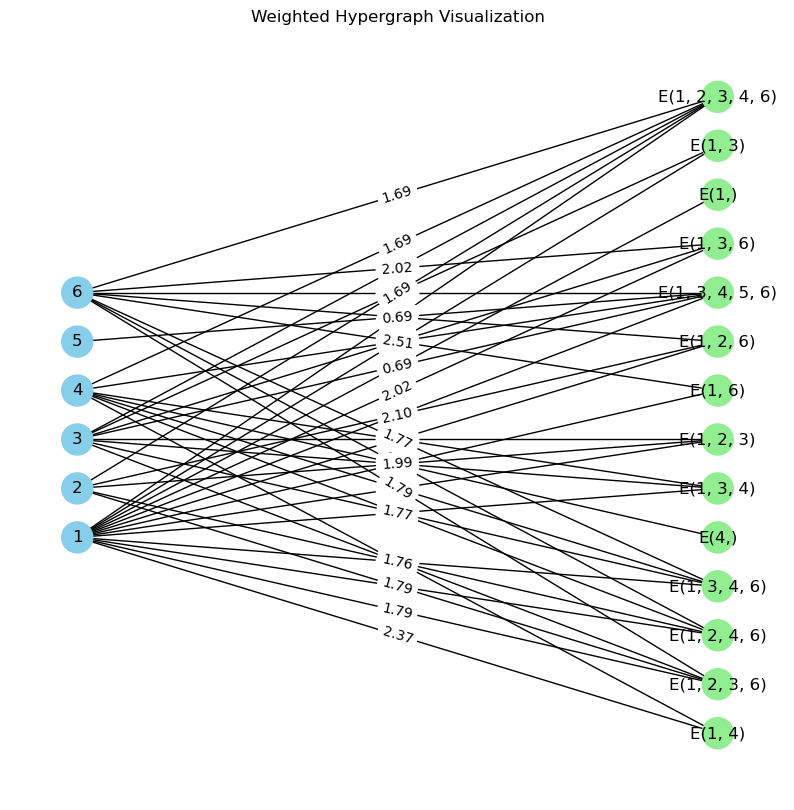

In [100]:
# Create a bipartite graph to represent the hypergraph
B = nx.Graph()

# Add nodes for each element in hyperedges
for edge, weight in Ninfomut.items():
    edge_label = f"E{edge}"  # Label for the hyperedge
    B.add_node(edge_label, bipartite=1, weight=weight)  # Hyperedge node
    for node in edge:
        B.add_node(node, bipartite=0)  # Add regular graph node
        B.add_edge(edge_label, node, weight=weight)  # Connect hyperedge to its nodes

# Extract positions for bipartite graph layout
pos_B = nx.multipartite_layout(B, subset_key="bipartite")

# Create a figure
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the nodes
node_colors = ["skyblue" if B.nodes[n]["bipartite"] == 0 else "lightgreen" for n in B.nodes()]
nx.draw_networkx_nodes(B, pos_B, node_color=node_colors, node_size=500, ax=ax)

# Draw the edges with weights
edge_labels = nx.get_edge_attributes(B, 'weight')
nx.draw_networkx_edges(B, pos_B, ax=ax)
nx.draw_networkx_labels(B, pos_B, ax=ax)

# Add edge weight labels
nx.draw_networkx_edge_labels(B, pos_B, edge_labels={e: f"{w:.2f}" for e, w in edge_labels.items()}, ax=ax)

# Set the title for the hypergraph
ax.set_title("Weighted Hypergraph Visualization")

# Turn off the axis
ax.axis("off")

# Display the plot
plt.show()